# PyTASER Materials Project Workflow

The following examples use data from the (legacy) Materials Project database to generate the predicted transient absorption spectra under various conditions. This takes advantage of pre-computed electronic structure from density functional theory (DFT).

**Note:** This notebook will require an API key that can be acquired from [here](https://legacy.materialsproject.org/janrain/loginpage/?next=/). This key can then be added to your *.pmgrc.yaml* file as below to prevent the need to repeatedly enter it:

 <!-- ```
 echo "PMG_MAPI_KEY: <YOUR_API_KEY>" >> ~/.pmgrc.yaml
 ``` -->

 ```
 pmg config --add PMG_MAPI_KEY <YOUR_API_KEY>
 ```

## Setup

In [ ]:
# Install package (if not done already)
!pip install git+https://github.com/WMD-group/PyTASER --quiet

In [1]:
%matplotlib inline
import numpy as np

from pytaser.kpoints import get_kpoint_weights
from pytaser.generator import TASGenerator
from pytaser.tas import Tas

## GaAs

### Materials Project Bandstructure

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

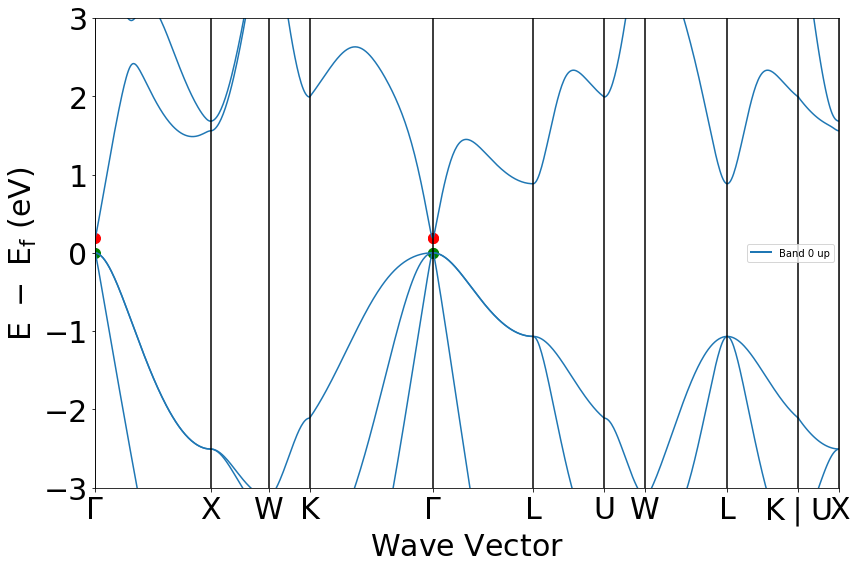

In [2]:
from pymatgen.ext.matproj import MPRester
from pymatgen.ext.matproj_legacy import TaskType
from pymatgen.electronic_structure.plotter import BSPlotter

mpr = MPRester()
bs = mpr.get_bandstructure_by_material_id("mp-2534")

from pymatgen.electronic_structure.plotter import BSPlotter

plt = BSPlotter(bs).get_plot(vbm_cbm_marker=True, ylim=[-3, +3])

In [3]:
bs.get_band_gap()

{'direct': True,
 'energy': 0.18610000000000015,
 'transition': '\\Gamma-\\Gamma'}

As shown from the above bandstructure, the MP database often underestimates material bandgaps. The experimental direct bandgap for GaAs is actually observed to be 1.5 eV.
<br>
<br>
This arises due to the use of semi-local exchange correlation (GGA) functionals in their calculations - to correct for this, we must apply a scissors operator and increase the bandgap to that of the inputted experimental bandgap. 

### Setting up the TASGenerator object

In [4]:
generator_2534 = TASGenerator.from_mpid("mp-2534", bg=1.5)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

The `from_mpid` method generates a TASGenerator object using the bandstructure and DOS objects imported from the MP database. As we have defined the `bg` argument as the experimental bandgap, the bandstructure and DOS objects are scissored accordingly, as can be seen in the below cell. 
<br> Additionally, this method generates kpoint-weightings for the inputted material, as long as it uses a uniform-mode kgrid for its bandstructure.

In [5]:
generator_2534.bs.get_band_gap()

{'direct': True,
 'energy': 1.5,
 'transition': '(0.000,0.000,0.000)-(0.000,0.000,0.000)'}

### Generating the TAS profiles

In [6]:
tas_2534 = generator_2534.generate_tas(
    temp=298,
    conc=1e18,  # inversely proportional to time delay
    energy_min=0.5,
    energy_max=5,
)
# generating the occupancies of each band using the Fermi-Dirac approx. implemented in pymatgen.
# externally generated occupancies can also be inputted if required.

The spectra can take a while to generate, depending on the number of bands and kpoints we are considering in the system. To save time during the (re-)analysis, it's generally best practice to save our generated TAS object to a `json` file.

In [7]:
from monty.serialization import dumpfn

dumpfn(tas_2534, "GaAs/tas_2534.json")

When we want to redo some of this analysis, in this notebook or a new one, we can load the TAS object from the `json` file, without having to re-generate the data. 

In [8]:
from monty.serialization import loadfn

tas_2534 = loadfn("GaAs/tas_2534.json")

### Plotting

Let's plot the predicted TAS spectrum for this material, under the conditions we specified above:

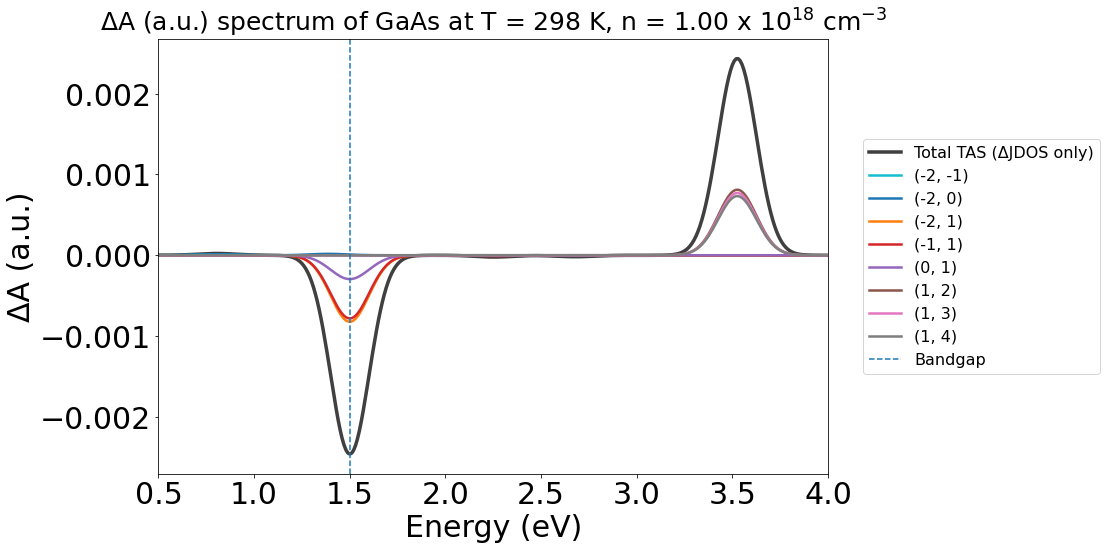

In [10]:
from pytaser.plotter import TASPlotter

plot_2534 = TASPlotter(tas_2534, material_name="GaAs")
energy_plot = plot_2534.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0.5, xmax=4, yaxis="jdos_diff"
)

Without the `WAVEDER` files used in the [PyTASER DFT Example](https://pytaser.readthedocs.io/en/latest/dft_examples.html), the TAS spectra we calculate does not consider oscillator strengths - it is just the change in joint density of states. Thus, the yaxis argument is set to `jdos_diff`.
<br>
<br>
We can also plot the spectra as a function of wavelength, by setting `xaxis="wavelength"` (and adjusting the `xmin` and `xmax` respectively)

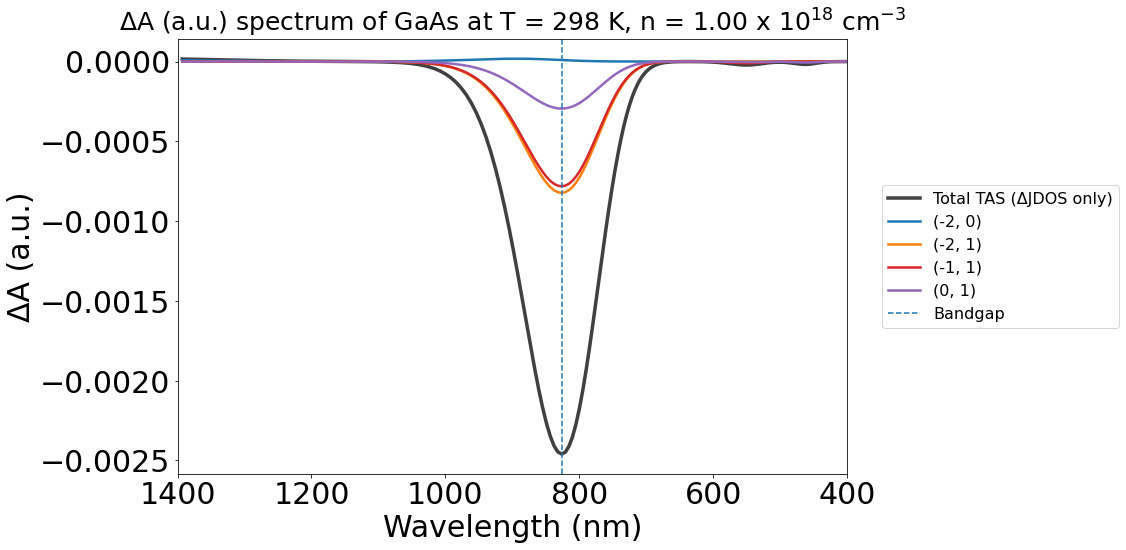

In [11]:
from pytaser.plotter import TASPlotter

plot_2534 = TASPlotter(tas_2534, material_name="GaAs")
energy_plot = plot_2534.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.01,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
)
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

### Joint Density of States (JDOS)

Another plotting option is to plot the individual JDOS spectra - to show the JDOS in the dark and under illumination separately. This will show the optically linked electronic states in their respective light conditions.

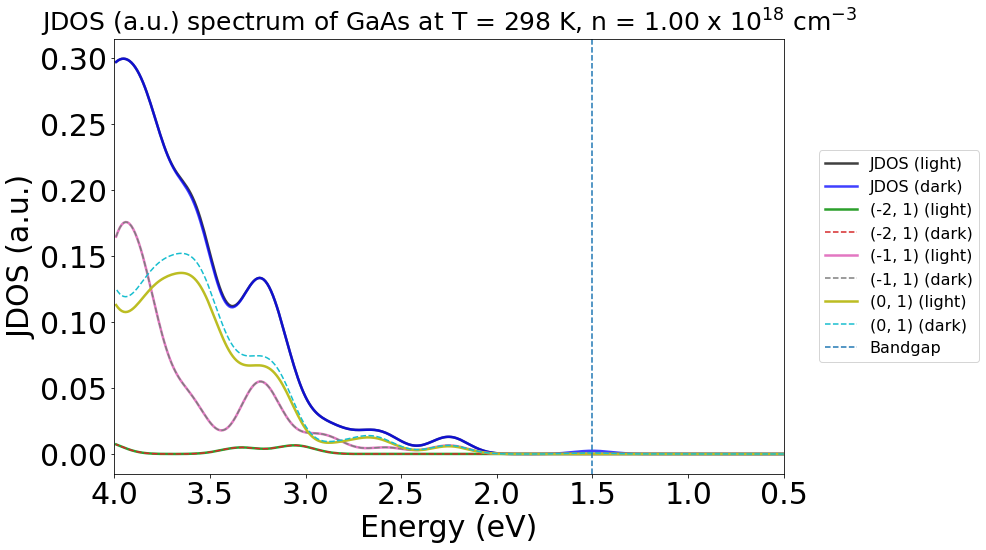

In [12]:
from pytaser.plotter import TASPlotter

plot_2534 = TASPlotter(tas_2534, material_name="GaAs")
energy_plot = plot_2534.get_plot(xaxis="energy", transition_cutoff=0.01, xmin=0.5, xmax=4, yaxis="jdos")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()

Here, we see notable differences between the dark (blue) and light (black) plots at ~3.5 eV and ~1.5 eV, matching with the peaks we see in the earlier `energy` TAS plot.

### Changing conditions

A significant advantage of predictive spectra is the ability to vary the system conditions. In PyTASER, the two main conditions we can change are the temperature of the system and the pump-probe time delay, which will both influence the occupancies of the bands based on the Fermi-Dirac approximation.
<br>

This is achieved by altering the `conc` and `temp` tags in the `generate_tas` method. We use the `conc` as an analogy of the pump-probe time delay, as the carrier concentration is inversely proportional to the time delay between initial excitation and absorption measurement. 
<br>

**Note:** At the moment, `conc` can only be qualitatively compared to the time delay - to make a quantitative comparison, we need to consider carrier recombination rates, which would differ with each system. Thus, this functionality should be used more to understand the origin of different spectral features, rather than to provide a full, quantitative comparison. 

In [4]:
import matplotlib.pyplot as plt

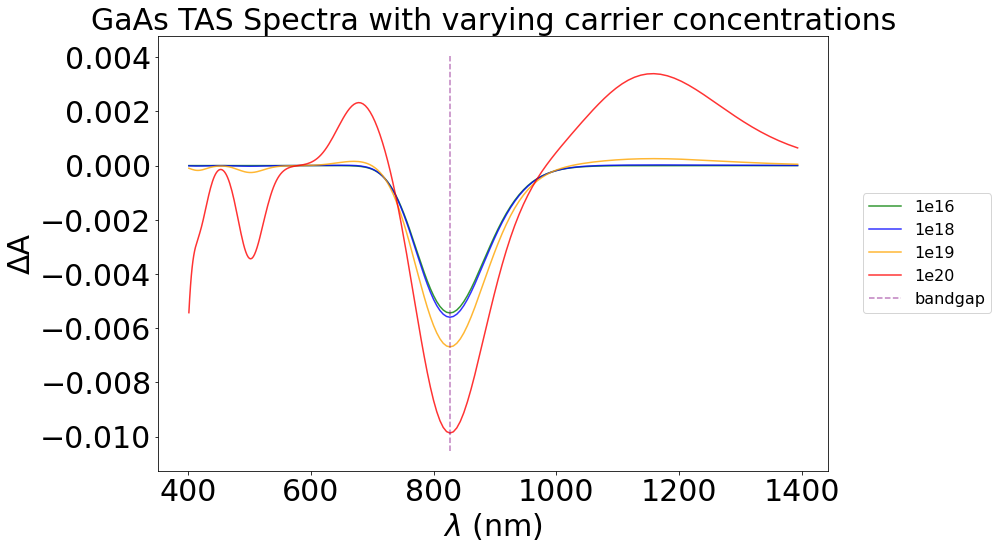

In [5]:
from monty.serialization import loadfn


conc_xydata = loadfn("GaAs/conc_xydata.json")

colors = ["green", "blue", "orange", "red", "purple"]
labels = ["1e16", "1e18", "1e19", "1e20", "bandgap"]
plt.figure(figsize=(12, 8))

for i, data in enumerate(conc_xydata):
    x = data[:, 0]
    y = data[:, 1]

    if labels[i] == "bandgap":
        # Plot the "bandgap" line as dashed
        plt.plot(x, y, color=colors[i], linestyle="--", label=labels[i], alpha=0.5)
    else:
        plt.plot(x, y, color=colors[i], label=labels[i], alpha=0.8)

plt.xlabel(r"$\lambda$ (nm)", fontsize=30)
plt.ylabel("ΔA", fontsize=30)
plt.title("GaAs TAS Spectra with varying carrier concentrations", fontsize=30)
plt.grid(False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc=("center left"), bbox_to_anchor=(1.04, 0.5), fontsize=(16))
plt.show()

Similarly, this can be done with varying temperatures.

**Note:** Due to limitations of the pymatgen FD approximation method used during the band occupancy generation stage, PyTASER cannot calculate system occupancies at 0 K. It may also struggle with other lower temperatures, but this is dependent on the bandgap of the sytem - usually anything above 25 K is fine. 

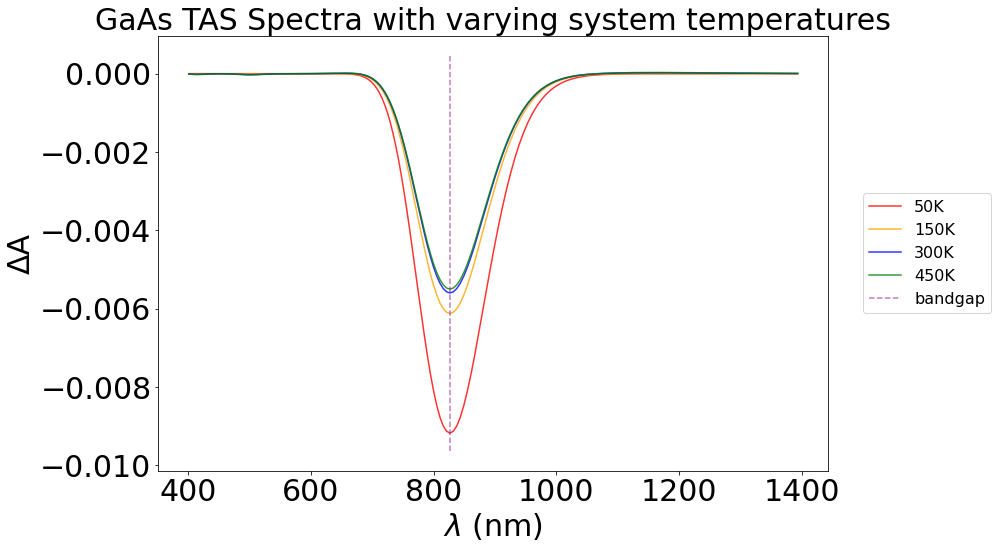

In [6]:
from monty.serialization import loadfn

temp_xydata = loadfn("GaAs/temp_xydata.json")

colors = ["red", "orange", "blue", "green", "purple"]
labels = ["50K", "150K", "300K", "450K", "bandgap"]
plt.figure(figsize=(12, 8))

for i, data in enumerate(temp_xydata):
    x = data[:, 0]
    y = data[:, 1]

    if labels[i] == "bandgap":
        # Plot the "bandgap" line as dashed
        plt.plot(x, y, color=colors[i], linestyle="--", label=labels[i], alpha=0.5)
    else:
        plt.plot(x, y, color=colors[i], label=labels[i], alpha=0.8)

plt.xlabel(r"$\lambda$ (nm)", fontsize=30)
plt.ylabel("ΔA", fontsize=30)
plt.title("GaAs TAS Spectra with varying system temperatures", fontsize=30)
plt.grid(False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc=("center left"), bbox_to_anchor=(1.04, 0.5), fontsize=(16))
plt.show()

With the above plot, we can observe a higher dip in the ΔA plot as we decrease temperature, in the bandgap region. At higher temperatures, electrons are thermally excited from the VBM, causing a lower change in absorption between the dark (just thermal excitation) and the light (thermal + photo excitation) - thus, a smaller overall change in the TAS spectrum at the bandgap. However, since a small number of carriers are already in their excited state at higher temperatures, we also see changes in regions away from the bandgap. This is hard to see in this system, but we can see small fluctutations between temperatures around the 500 nm and 1100 nm marks. 

### Individual band transitions

We can visualise individual the contribution of individual band transition to the overall spectrum, whether JDOS or TAS. These individual transition contributions can be very useful to highlight specific spectral features in the overall spectra. This can be a big time-saver for quick analysis, as the numerically accurate method uses a series of complicated Fourier transforms to  isolate these contributions.

**Note:** The likelihood of each band transition happening is linked to the transition probability (and thus the oscillator strength, as used in the [DFT example](https://pytaser.readthedocs.io/en/latest/dft_examples.html)). This is not possible to include here, due to limitations in the MP database, so the overall spectrum may differ qualitatively to experimental spectra, especially those with long recombination times!

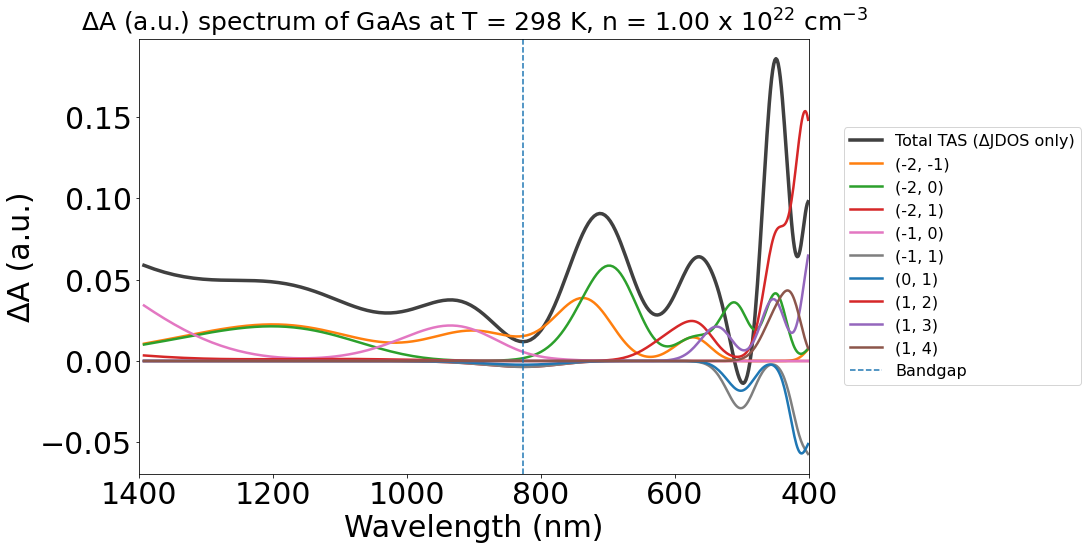

In [33]:
conc_22 = loadfn("GaAs/gaas_conc_22.json")
plot_22 = TASPlotter(conc_22, material_name="GaAs")
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.01,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    invert_axis=True
)
# Reverse axis for better comparison to experiment
# energy_plot_22.gca().invert_xaxis()

Here, the labels (-2,-1), etc. all refer to the band number. The first number refers to the initial band that hosts the electron before excitation, and the second number refers to the final band that it is excited to. 

Negative band numbers refer to bands in the valence band continua (VBM as Band *#0*), and positive bands refer to bands in the conduction band continua (CBM as Band *#1*).


Additionally, we can adjust the contribution threshold `transition cutoff` of the plots to get rid of less important transitions. The maximum of this is 1.0, which will show the largest contributing transition only. 

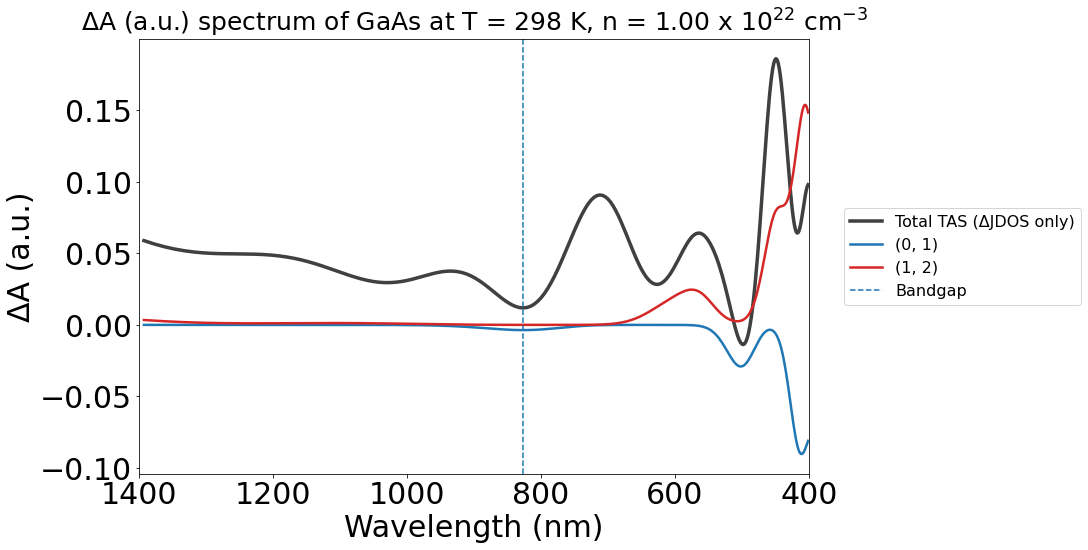

In [31]:
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.5,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    invert_axis=True
)
# Reverse axis for better comparison to experiment
# energy_plot_22.gca().invert_xaxis()

## Plot Customisability

Being a `pyplot` object, we can edit the plot's size, colour, title, etc. after generating it, using [standard  integrated matplotlib features](https://www.datacamp.com/cheat-sheet/matplotlib-cheat-sheet-plotting-in-python).

As such, this section includes a few of the customisations that might be more relevant for comparisons with experiment and to make the plots more publication-ready. As the code develops, we hope to add more functionality to make it more interactive and visually appealing.

#### X-axis inversion

Varying experimental literature can present different axes directions in the x-axis, especially when comparing between wavelengths and electronvolts. To allow for a more fluid comparison between the outputs from PyTASER and literature, we can use the `inverse_axis` Boolean variable when plotting the spectrum to flip the x-axis direction.  

The non-inverted version:

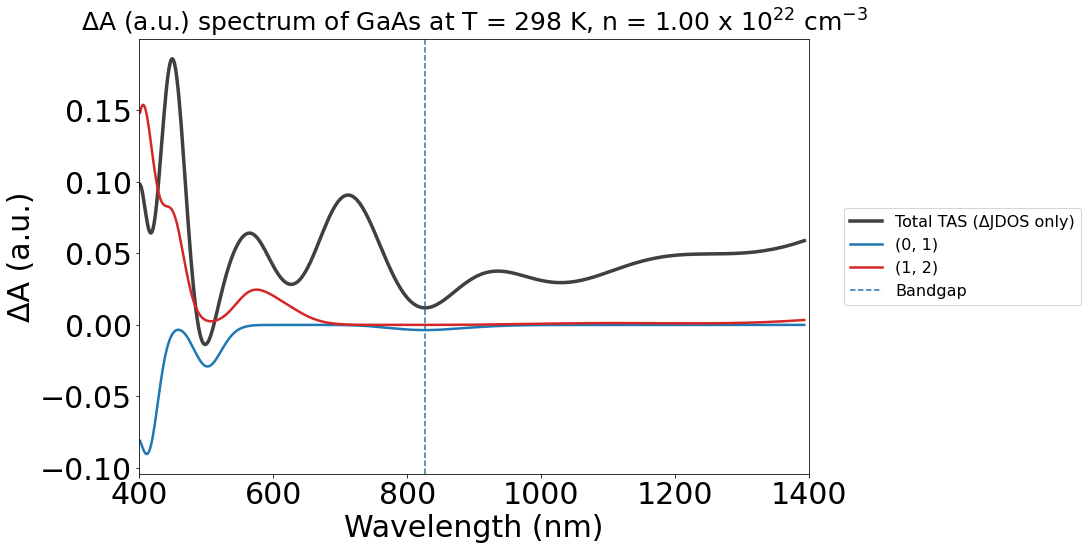

In [56]:
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.5,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    # invert_axis=True
)

The inverted version:

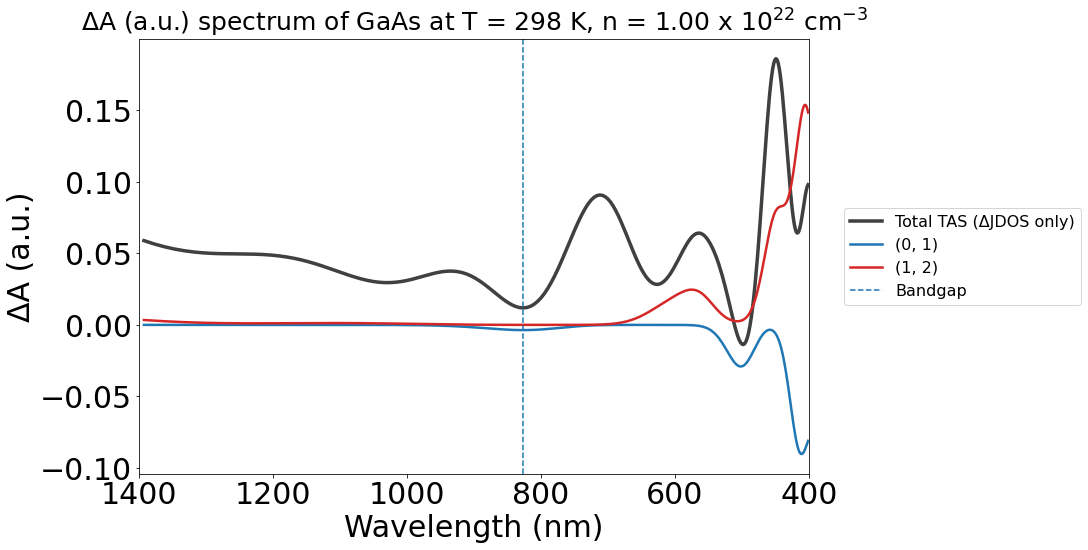

In [58]:
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.5,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    invert_axis=True
)

#### Changing color themes

Although PyTASER's functionality ensures that the colors are consistent for band-transitions between different plots, it is also relatively easy to change the colours of the lines as you want. 

An example is shown below, with a simple code written to change the color of the (0, 1) band transition from `blue` to `sandybrown`.  A loop can also be used if this is required for multiple lines.

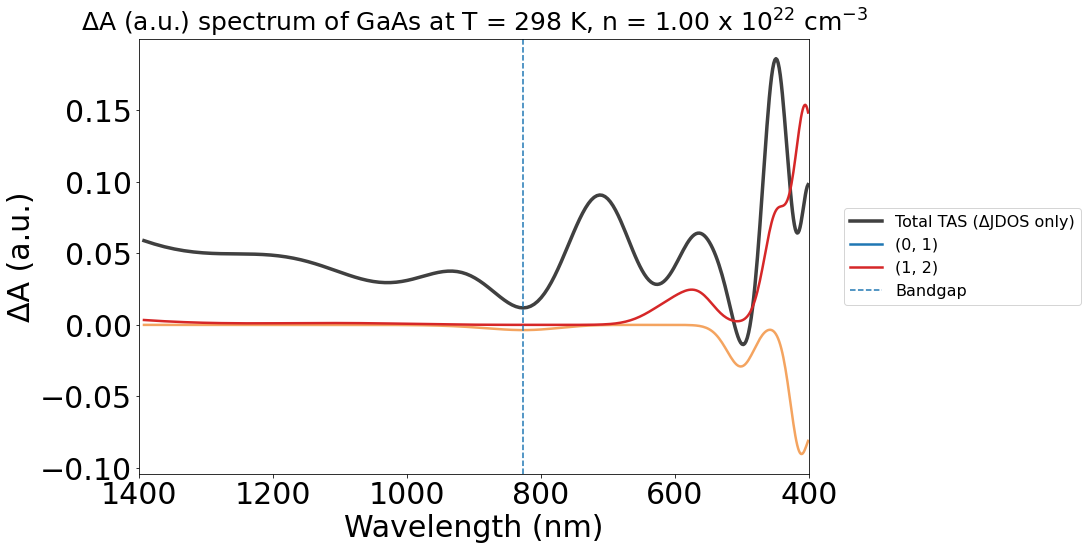

In [71]:
import matplotlib.pyplot as plt


#Generate the plot as before
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.5,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    invert_axis=True
)

# Suppose you want to change the color of the line labeled "(0, 1)"
target_label = "(0, 1)" # This must be a string, and must match the label shown in the legend.
new_color = "sandybrown"  # New color you want to assign to the line - can be anything recognised by matplotlib

# Get the lines in the current Axes
lines = energy_plot_22.gca().get_lines()

# Iterate over the lines and find the one with the target label
for line in lines:
    if line.get_label() == target_label:
        # Change the color of the line
        line.set_color(new_color)
        break  # Exit the loop once the line is found

# Show or save the plot
plt.show()


#### Saving the plot 

To save the plot, we can use the `savefig()` method on the generated plot. As the legend is placed outside of the plot, it can be saved separately using the `get_legend()` method on the `gca()` object and then included like shown below.

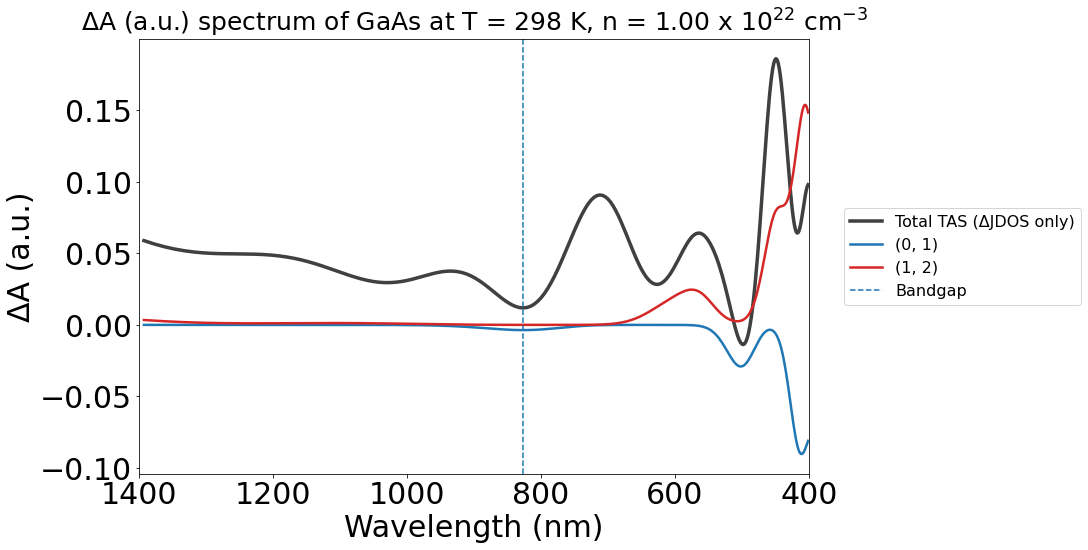

In [55]:
# Generate the plot, as before
energy_plot_22 = plot_22.get_plot(
    xaxis="wavelength",
    transition_cutoff=0.5,
    xmin=400,
    xmax=1400,
    yaxis="jdos_diff",
    invert_axis=True
)

# Set the legend as a variable
lgd=energy_plot_22.gca().get_legend()

# Save the figure 
energy_plot_22.savefig(fname='GaAs/GaAs_savedfig.png', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)
    #fname sets the output location and name where the generated plot will be saved. 

The saved plot can be seen in the GaAs example folder, as a png file. 

Many types of output are supported, including raster formats like PNG, GIF, JPEG, TIFF and vector formats like PDF, EPS, and SVG.